# Filtering and Data Mining


In [42]:
import os
import pymongo
from pymongo import MongoClient

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')
# Preprocesado y modelado
# ==============================================================================

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# Configuración warnings
# ==============================================================================
import warnings


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ceciliocannavaciuolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Get data from MongoDB

In [44]:
# Connect with DB
MONGODB_URL = os.environ.get('MONGODB_URL')
NODE_ENV = os.environ.get('NODE_ENV') or "dev"
DB_NAME = os.environ.get('APP_NAME') + "-"+ NODE_ENV

client = MongoClient()
client = MongoClient(MONGODB_URL)
db = client[DB_NAME]

# jobs = db.gitlablogs.find({}).limit(100) # Read all data

jobs = db.gitlablogs.find({}) # Read all data

jobs = pd.DataFrame(list(jobs)) # Convert to DataFrame

print(jobs.columns)



Index(['_id', 'jobId', 'projectId', '__v', 'allow_failure', 'commitId',
       'commitMessage', 'commitTitle', 'committedEmail', 'created_at',
       'duration', 'jobName', 'jobRef', 'jobStage', 'jobStatus', 'pipelineId',
       'pipelineRef', 'pipelineStatus', 'pipelineUrl', 'pipelineWebUrl',
       'projectDescriptions', 'projectName', 'projectNameWithNamespace',
       'queued_duration', 'runnerDescription', 'runnerId', 'runnerIpAddress',
       'runnerName', 'sha', 'started_at', 'username', 'jobLog'],
      dtype='object')


# Log data cleaning
## In this step, all non-relevant information is removed from the analysis.
    - Remove special characters

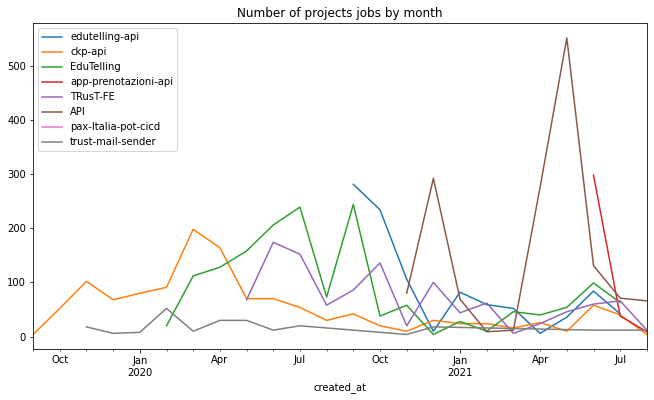

In [7]:
# Temporal distribution of Jobs
# ==============================================================================
fig, ax = plt.subplots(figsize=(11,6))

for projectName in jobs.projectName.unique():
    df_temp = jobs[jobs['projectName'] == projectName].copy()
    df_temp['created_at'] = pd.to_datetime(df_temp['created_at'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['created_at']).size()
    df_temp.plot(label=projectName, ax=ax)

ax.set_title('Number of projects jobs by month')
ax.legend();

# Clean Data

In [8]:


def limpiar_tokenizar(texto):

    blackListWold = ["containerd","ms", "io", "time", "msg", "false", "true", "src", "openshift", "echgap", "runner", "rc", "m", "level"]
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)

 
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')

    #! Apply black list

    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if (len(token) > 1 and token not in blackListWold)]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [9]:
# The cleaning and tokenization function is applied to each job
# ==============================================================================
jobs['jobLog_token'] = jobs['jobLog'].apply(lambda x: limpiar_tokenizar(x))
jobs[['jobLog', 'jobLog_token']].head()

,jobLog,jobLog_token
0,[0KRunning with gitlab-runner 14.1.0-rc1 (e94...,"[krunning, with, gitlab, m, on, docker, auto,..."
1,[0KRunning with gitlab-runner 14.1.0-rc1 (e94...,"[krunning, with, gitlab, m, on, docker, auto,..."
2,[0KRunning with gitlab-runner 14.1.0-rc1 (e94...,"[krunning, with, gitlab, m, on, docker, auto,..."
3,[0KRunning with gitlab-runner 14.1.0-rc1 (e94...,"[krunning, with, gitlab, m, on, docker, auto,..."
4,[0KRunning with gitlab-runner 14.1.0-rc1 (e94...,"[krunning, with, gitlab, m, on, docker, auto,..."


# Exploratory analysis

### In Python, one of the structures that most facilitates exploratory analysis is the Pandas DataFrame, which is the structure in which the information from the jobs is now stored. However, when tokenizing, there has been a major change. Before dividing the text, the study elements were the jobs, and each one was in a row, thus fulfilling the condition of tidy data: an observation, a row. When performing the tokenization, the element of study has become each token (word), thus violating the condition of tidy data. To get back to the ideal structure, each token list has to be expanded, doubling the value of the other columns as many times as necessary. This process is known as expansion or unnest.


### Although it may seem an inefficient process (the number of rows increases a lot), this simple change facilitates activities of the type: grouping, counting, graphics ...


In [10]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
jobs_tidy = jobs.explode(column='jobLog_token')
jobs_tidy = jobs_tidy.drop(columns='jobLog')
jobs_tidy = jobs_tidy.rename(columns={'jobLog_token':'token'})
jobs_tidy.head(10)


,_id,jobId,projectId,__v,allow_failure,commitId,commitMessage,commitTitle,committedEmail,created_at,...,projectNameWithNamespace,queued_duration,runnerDescription,runnerId,runnerIpAddress,runnerName,sha,started_at,username,token
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,krunning
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,with
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,gitlab
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,m
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,on
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,docker
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,auto
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStagesByTeacherId' into...,c.cannavacciuolo@anoki.it,2021-07-26 15:10:20.281,...,Anoki S.r.l. / EDUtelling-Prj / edutelling-api,0.257544,shared-runners-manager-7,None,35.237.21.158,gitlab-runner,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,2021-07-26 15:23:34.058,cecilio.cannav,scale
0,611102da01a14071451c22c7,1452810390,15112024,0,False,fa3cb44c5c76f4955d7b63f6159bc17916c4a29b,Merge branch '226-A-getStagesByTeacherId' into...,Merge branch '226-A-getStage

# Total words used by each log event

In [1]:
jobs_tidy.groupby(by='jobStatus')['token'].count()

NameError: name 'jobs_tidy' is not defined

# Total words used by each project

In [12]:
jobs_tidy.groupby(by='projectName')['token'].count()

projectName
API                     17542245
EduTelling               4007091
TRusT-FE                42997103
app-prenotazioni-api     1219649
ckp-api                  1313933
edutelling-api           1453082
pax-Italia-pot-cicd         2615
trust-mail-sender         197901
Name: token, dtype: int64

# Frequency of words

In [13]:
# Total words per event
# ==============================================================================
print('--------------------------')
print('Total words per event')
print('--------------------------')
jobs_tidy.groupby(by='jobStatus')['token'].nunique()



--------------------------
Total words per event
--------------------------


jobStatus
canceled     2091
failed       5883
skipped         0
success     10249
Name: token, dtype: int64

# Average length of each event logs

In [14]:
# Longitud media y desviación de los jobs de cada jobStatus
# ==============================================================================
temp_df = pd.DataFrame(jobs_tidy.groupby(by = ["jobStatus", "jobId"])["token"].count())
temp_df.reset_index().groupby("jobStatus")["token"].agg(['mean', 'std'])

,mean,std
jobStatus,,
canceled,602.186192,6400.751998
failed,6306.405333,23604.956002
skipped,0.000000,0.000000
success,12397.404748,33442.831098


# Most used words by event

In [16]:
# Top 50 palabras más utilizadas por cada evento
# ==============================================================================
jobs_tidy.groupby(['jobStatus','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('jobStatus') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(10))
 

jobStatus        token    count
jobStatus                                      
canceled  1033   canceled           kb   159642
          1157   canceled           mb   142636
          1425   canceled     progress    79256
          798    canceled         from     8059
          285    canceled      central     7820
          945    canceled         info     4698
          594    canceled   downloaded     3921
          121    canceled           at     3920
          595    canceled  downloading     3917
          1375   canceled       plugin     3089
failed    4985     failed           kb   161733
          5314     failed           mb   139760
          6033     failed     progress    88779
          5457     failed      modules    77109
          5602     failed         node    66992
          2322     failed          app    37309
          7404     failed          usr    37134
          5164     failed       loader    36271
          7681     failed      vuetify    36250
          6931     failed       styles    33787
success   14104   success      modules  4539062
          13340   success           kb  4048192
          13870   success           mb  3897683
          15080   success     progress  2583197
          9270    success     building  2296929
          8181    success       active  2293084
          13265   success           js  2275385
          17429   success          vue  2131288
          8469    success          app  2027036
          14380   success         node  1880780

# Stop words


### In the table above it can be seen that the most frequent terms in all users correspond to articles, prepositions, pronouns ..., in general, words that do not provide relevant information about the text. These words are known as stopwords. For each language there are different lists of stopwords, in addition, depending on the context, it may be necessary to adapt the list. For example, in the table above, the term amp appears from the html & amp tag. Often times, as an analysis is carried out, words are found that should be included in the list of stopwords.

In [17]:
# Obtaining a list of stopwords in English
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [18]:
# Filtering to exclude stopwords
# ==============================================================================
jobs_tidy = jobs_tidy[~(jobs_tidy["token"].isin(stop_words))]

Error


/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0, flags=flags)


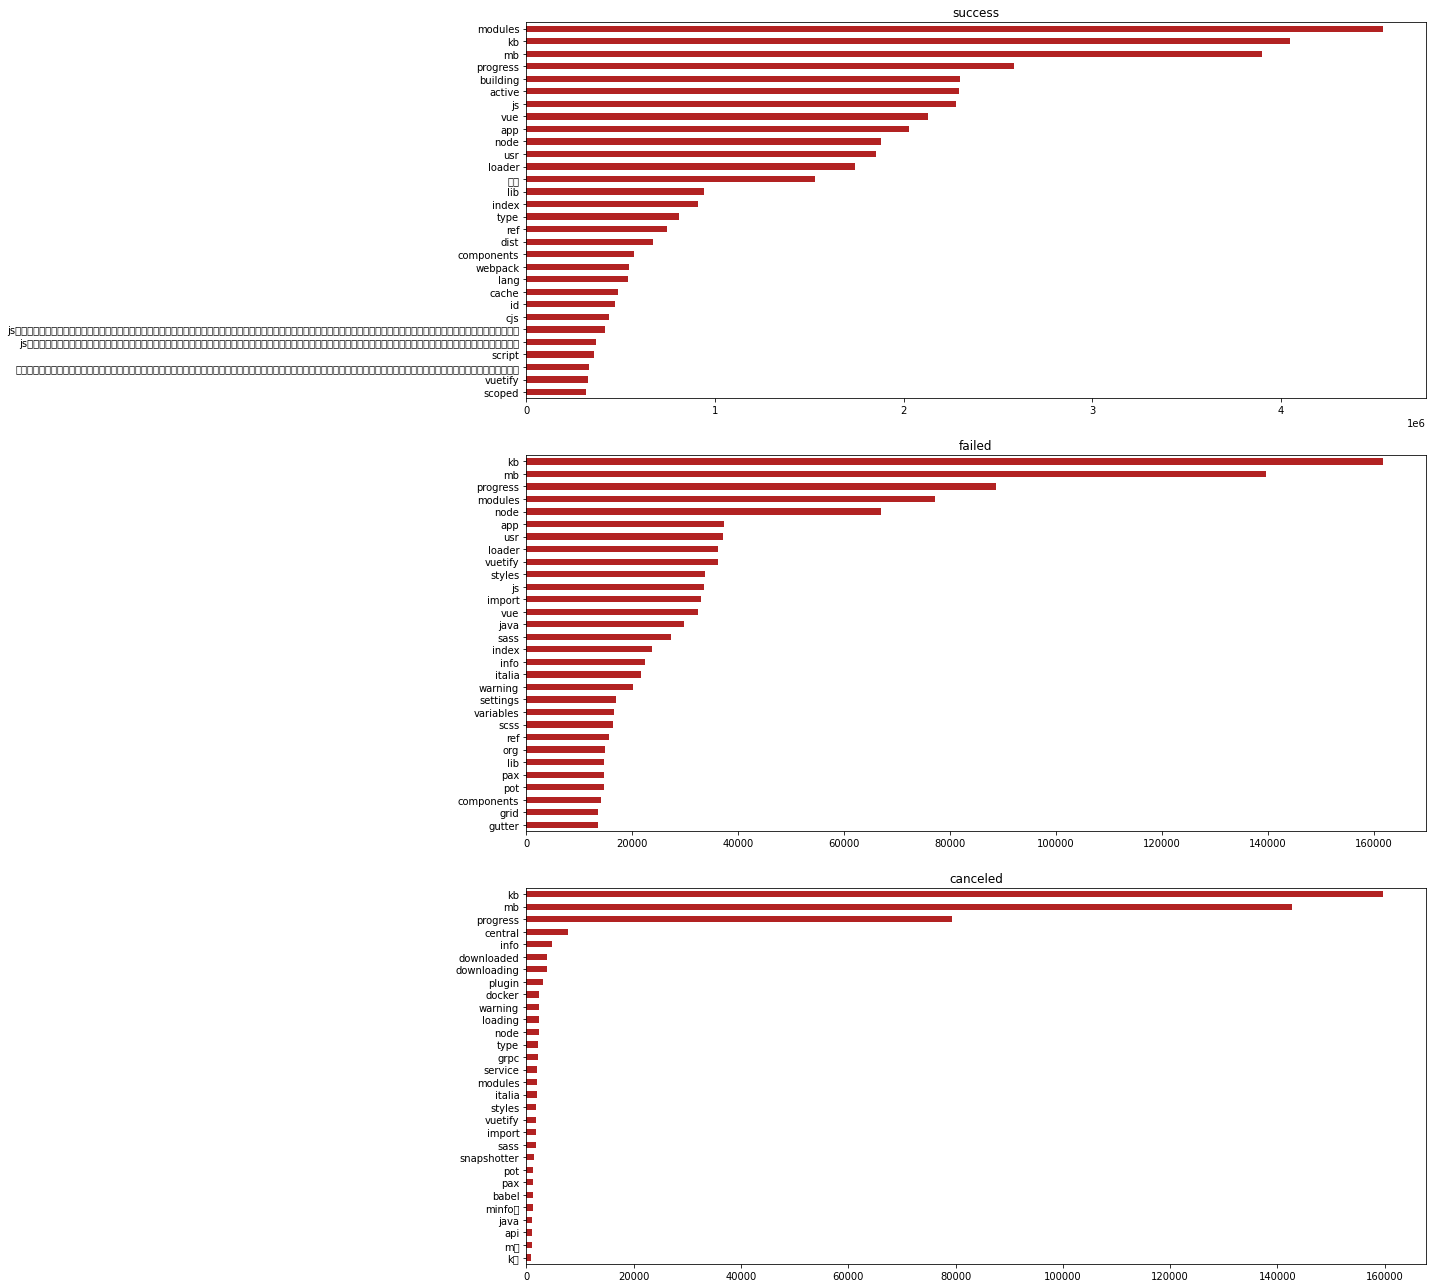

In [20]:
# Top 10 palabras por jobStatus (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(20, 18))
for i, jobStatus in enumerate(jobs_tidy.jobStatus.unique()):

    try:
        df_temp = jobs_tidy[jobs_tidy.jobStatus == jobStatus]
        counts  = df_temp['token'].value_counts(ascending=False).head(30)
        counts.plot(kind='barh', color='firebrick', ax=axs[i])
        axs[i].invert_yaxis()
        axs[i].set_title(jobStatus)
    except:
        print("Error")

fig.tight_layout()



# Correlation between states

In [21]:
# Data pivot
# ==============================================================================
jobs_pivot = jobs_tidy.groupby(["jobStatus","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="jobStatus", values= "count")
jobs_pivot.columns.name = None

# Correlation test (cosine) for the use and frequency of words
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

jobs_pivot.corr(method=similitud_coseno)

,canceled,failed,success
canceled,1.000000,0.817969,0.630066
failed,0.817969,1.000000,0.854207
success,0.630066,0.854207,1.000000


/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0, flags=flags)


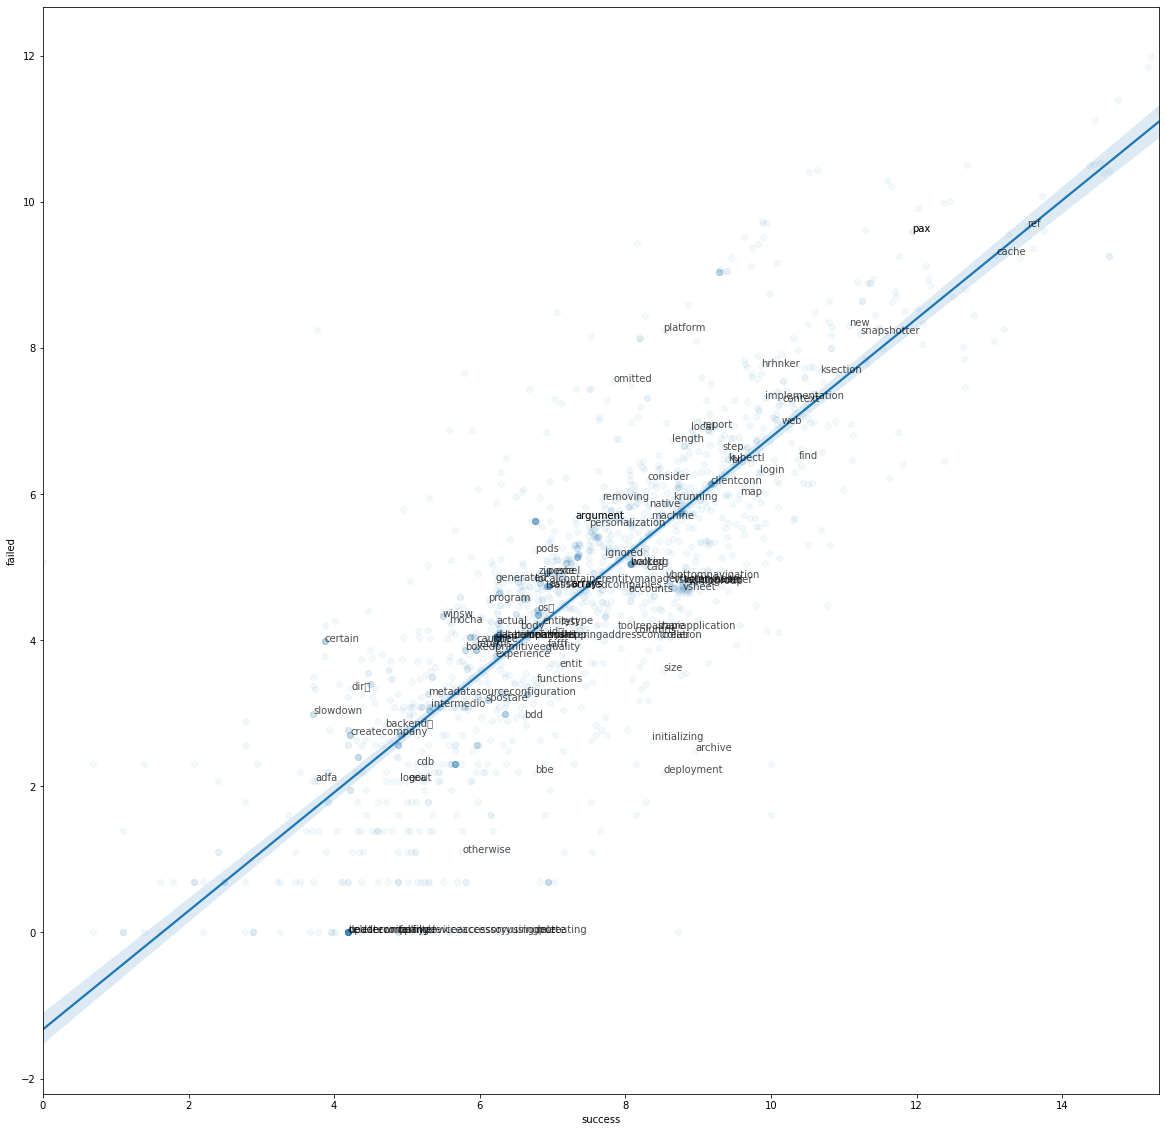

In [23]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(20, 20))
temp = jobs_pivot.dropna()
sns.regplot(
    x  = np.log(temp.success),
    y  = np.log(temp.failed),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);

for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.success[i]), np.log(temp.failed[i])),
        alpha = 0.7
    )

In [24]:
# Número de palabras comunes
# ==============================================================================
palabras_failed = set(jobs_tidy[jobs_tidy.jobStatus == 'failed']['token'])
palabras_success = set(jobs_tidy[jobs_tidy.jobStatus == 'success']['token'])

print(f"Palabras comunes entre failed y success {len(palabras_failed.intersection(palabras_success))}")

Palabras comunes entre failed y success 3976


In [25]:
# Cálculo del log of odds ratio de cada palabra (failed vs success)
# ==============================================================================
# Pivotaje y despivotaje
jobs_pivot = jobs_tidy.groupby(["jobStatus","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="jobStatus", values= "count")

jobs_pivot = jobs_pivot.fillna(value=0)
jobs_pivot.columns.name = None

jobs_unpivot = jobs_pivot.melt(value_name='n', var_name='jobStatus', ignore_index=False)
jobs_unpivot = jobs_unpivot.reset_index()

# Selección de los jobStatuses failed y success
jobs_unpivot = jobs_unpivot[jobs_unpivot.jobStatus.isin(['failed', 'success'])]

# Se añade el total de palabras de cada jobStatus
jobs_unpivot = jobs_unpivot.merge(
                    jobs_tidy.groupby('jobStatus')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'jobStatus'
                 )

# Cálculo de odds y log of odds de cada palabra
jobs_logOdds = jobs_unpivot.copy()
jobs_logOdds['odds'] = (jobs_logOdds.n + 1) / (jobs_logOdds.N + 1)
jobs_logOdds = jobs_logOdds[['token', 'jobStatus', 'odds']] \
                    .pivot(index='token', columns='jobStatus', values='odds')
jobs_logOdds.columns.name = None

jobs_logOdds['log_odds']     = np.log(jobs_logOdds.failed/jobs_logOdds.success)
jobs_logOdds['abs_log_odds'] = np.abs(jobs_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como failed/success.
jobs_logOdds['jobStatus_frecuente'] = np.where(jobs_logOdds.log_odds > 0,
                                              "failed",
                                              "success"
                                    )

print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
jobs_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,failed,success,log_odds,abs_log_odds,jobStatus_frecuente
token,,,,,
abstractautowirecapablebeanfactory,1.293068e-03,1.573264e-08,11.316791,11.316791,failed
launcher,1.050820e-03,1.573264e-08,11.109344,11.109344,failed
na,9.713038e-04,1.573264e-08,11.030657,11.030657,failed
abstractbeanfactory,8.825411e-04,1.573264e-08,10.934823,10.934823,failed
,4.623055e-07,2.402901e-02,-10.858547,10.858547,success
jupiter,6.245747e-04,1.573264e-08,10.589089,10.589089,failed
hierarchical,5.496812e-04,1.573264e-08,10.461356,10.461356,failed
classbasedtestdescriptor,5.496812e-04,1.573264e-08,10.461356,10.461356,failed
nodetesttask,4.997522e-04,1.573264e-08,10.366130,10.366130,failed


/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


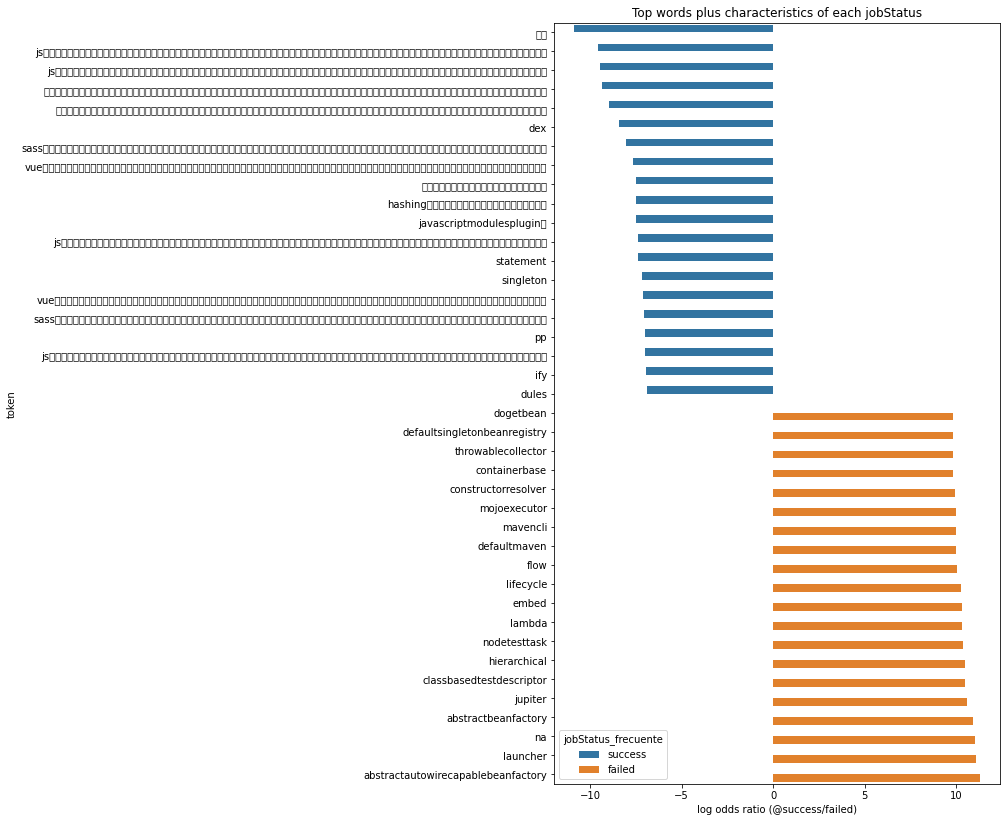

In [26]:
# Top 15 palabras más características de cada jobStatus
# ==============================================================================

top_30 = jobs_logOdds[['log_odds', 'abs_log_odds', 'jobStatus_frecuente']] \
        .groupby('jobStatus_frecuente') \
        .apply(lambda x: x.nlargest(20, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(8, 14))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'jobStatus_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top words plus characteristics of each jobStatus')
ax.set_xlabel('log odds ratio (@success/failed)');